# Importazione librerie, dati, tokenizzazione e pulizia

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Carica il file CSV contenente le descrizioni
descrizioni_df = pd.read_csv('descrizioni_prodotti.csv')


# Tokenizzazione delle descrizioni
descrizioni_df['Tokenized_Descrizione'] = descrizioni_df['Descrizione'].apply(word_tokenize)

# Rimozione delle stopwords e pulizia del testo
stop_words = set(stopwords.words('italian'))
pulizia_regex = re.compile(r"[^\w\s]")

def pulisci_testo(testo):
    testo_pulito = [pulizia_regex.sub('', parola.lower()) for parola in testo if pulizia_regex.sub('', parola.lower()) and parola.lower() not in stop_words]
    return testo_pulito

descrizioni_df['Descrizione_Pulita'] = descrizioni_df['Tokenized_Descrizione'].apply(pulisci_testo)

# Unione di tutte le parole nelle descrizioni pulite
tutte_le_parole = [parola for lista_parole in descrizioni_df['Descrizione_Pulita'] for parola in lista_parole]

# Calcolo della frequenza delle parole
frequenza_parole = Counter(tutte_le_parole)

# Creazione di un DataFrame per le frequenze delle parole
frequenza_df = pd.DataFrame.from_dict(frequenza_parole, orient='index', columns=['Frequenza'])
frequenza_df.index.name = 'Parola'
frequenza_df.sort_values(by='Frequenza', ascending=False, inplace=True)

# Visualizzazione delle prime 20 parole più frequenti
print("Parole più frequenti:")
print(frequenza_df.head(20))

Parole più frequenti:
                 Frequenza
Parola                    
vitamina                16
normale                 13
magnesio                12
autoriscaldanti         12
medico                  10
funzione                10
prodotto                10
fascia                   9
versatile                9
anni                     7
xl                       7
muscolare                7
bambini                  7
prima                    7
papaya                   7
dolore                   7
consultare               6
vita                     6
acido                    6
calore                   6


# Grafico parole più frequenti

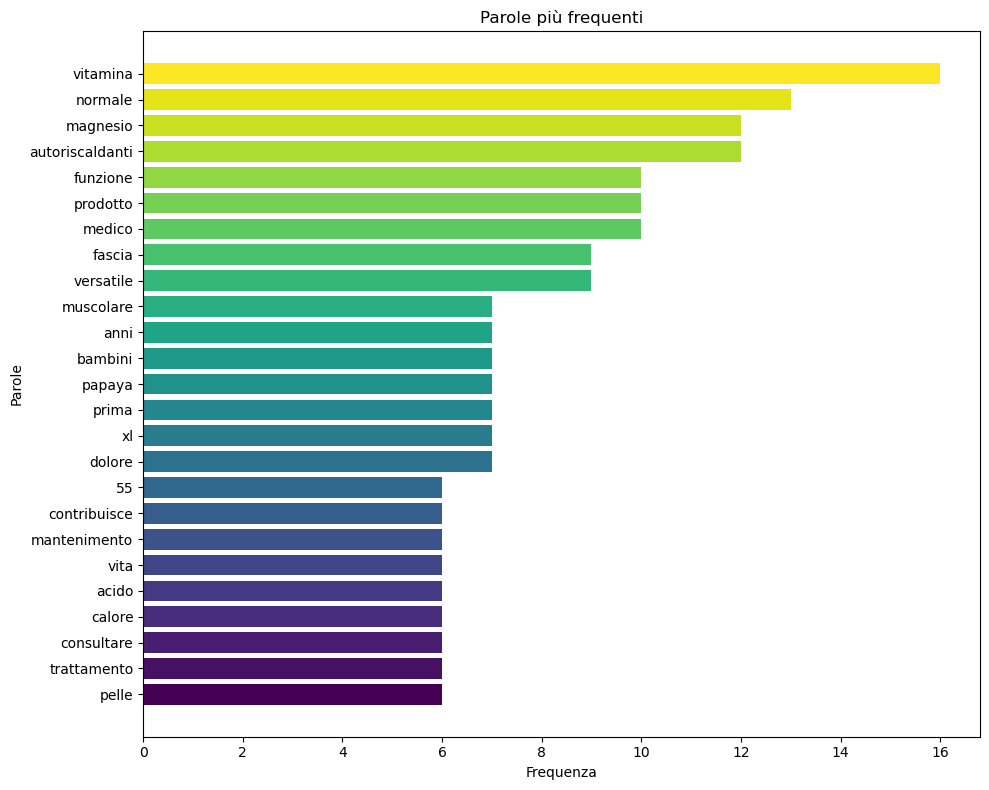

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

# Estraiamo le parole e le relative frequenze
parole, frequenze = zip(*frequenza_parole.most_common(25))

# Creiamo una scala di colori viridis basata sulle frequenze (invertendo l'ordine)
colori = plt.cm.viridis(np.linspace(1, 0, len(parole)))  # Invertiamo l'ordine qui

# Creiamo il grafico a barre orizzontale con colori viridis (invertiti)
plt.figure(figsize=(10, 8))
plt.barh(parole, frequenze, color=colori)
plt.ylabel('Parole')
plt.xlabel('Frequenza')
plt.title('Parole più frequenti')
plt.gca().invert_yaxis()  # Inverti l'asse y per avere la parola più frequente in cima
plt.tight_layout()  # Imposta i margini in modo da non tagliare le etichette
plt.show()


# Vicinanza delle 50 parole più frequenti tramite Word2Vec

In [ ]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from adjustText import adjust_text

# Caricamento delle descrizioni da file
descrizioni_df = pd.read_csv('descrizioni_prodotti.csv')


# Tokenizzazione delle descrizioni
descrizioni_df['Tokenized_Descrizione'] = descrizioni_df['Descrizione'].apply(word_tokenize)

# Rimozione delle stopwords e pulizia del testo
stop_words = set(stopwords.words('italian'))
pulizia_regex = re.compile(r"[^\w\s]")

def pulisci_testo(testo):
    testo_pulito = [pulizia_regex.sub('', parola.lower()) for parola in testo if pulizia_regex.sub('', parola.lower()) and parola.lower() not in stop_words]
    return testo_pulito

descrizioni_df['Descrizione_Pulita'] = descrizioni_df['Tokenized_Descrizione'].apply(pulisci_testo)

# Creazione del modello Word2Vec
sentences = descrizioni_df['Descrizione_Pulita'].tolist()
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4, sg=1)

# Estrazione delle 10 parole più comuni
all_words = [word for sentence in sentences for word in sentence]
most_common_words = [word for word, count in Counter(all_words).most_common(50)]

# Ottenimento dei vettori per le parole più comuni
word_vectors = [word2vec_model.wv[word] for word in most_common_words]

# Conversione in array NumPy
word_vectors_np = np.array(word_vectors)

# Calcolo delle frequenze delle parole più comuni
frequencies = [count for word, count in Counter(all_words).most_common(50)]

# Riduzione dimensionale con TSNE
tsne_model = TSNE(n_components=2, random_state=0, perplexity=2)
word_vectors_2d = tsne_model.fit_transform(word_vectors_np)

# Creazione di un dizionario che mappa le parole ai rispettivi 'ProdottoID'
word_to_prodotto = {}
for prodotto_id, descrizione in zip(descrizioni_df['Prodotto'], descrizioni_df['Descrizione_Pulita']):
    for word in descrizione:
        if word in most_common_words:
            word_to_prodotto[word] = prodotto_id

# Associazione dei colori ai 'ProdottoID'
unique_prodotto_ids = descrizioni_df['Prodotto'].unique()
palette = sns.color_palette('hsv', len(unique_prodotto_ids))
prodotto_id_to_color = {prod_id: palette[i] for i, prod_id in enumerate(unique_prodotto_ids)}

# Creazione del grafico
plt.figure(figsize=(12, 8))
scatter_points = []
texts = []
for i, word in enumerate(most_common_words):
    prod_id = word_to_prodotto[word]
    color = prodotto_id_to_color[prod_id]
    point = plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1], s=frequencies[i]*20, color=color, label=prod_id)
    scatter_points.append(point)
    texts.append(plt.text(word_vectors_2d[i, 0], word_vectors_2d[i, 1], word, fontsize=10))

# Regolazione automatica dell'etichettatura
adjust_text(texts, arrowprops={})

# Creazione della legenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Vicinanza delle 50 parole più frequenti tramite Word2Vec')
plt.grid(True)  # Aggiunta della griglia per migliore leggibilità
plt.show()


# Wordcloud delle parole più frequenti

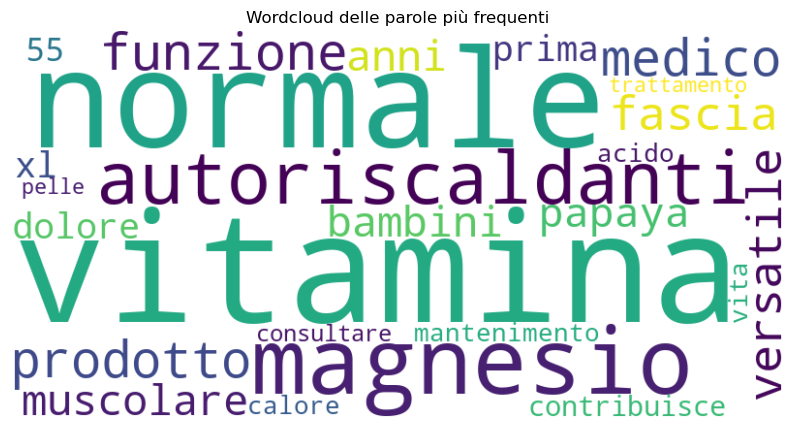

In [5]:
from wordcloud import WordCloud

# Creiamo un dizionario con le parole e le loro frequenze
parole_frequenze = dict(zip(parole, frequenze))

# Creiamo la wordcloud
wordcloud = WordCloud(width=800, height=400, colormap='viridis', background_color = "white").generate_from_frequencies(parole_frequenze)

# Visualizziamo la wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud delle parole più frequenti')
plt.show()


In [6]:
from nltk.util import ngrams

# Funzione per estrarre bigrammi e trigrammi da una lista di parole
def estrai_ngram(parole, n):
    return list(ngrams(parole, n))

# Estrai bigrammi e trigrammi da tutte le descrizioni pulite
descrizioni_df['Bigrammi'] = descrizioni_df['Descrizione_Pulita'].apply(lambda x: estrai_ngram(x, 2))
descrizioni_df['Trigrammi'] = descrizioni_df['Descrizione_Pulita'].apply(lambda x: estrai_ngram(x, 3))

# Calcola la frequenza dei bigrammi e trigrammi
frequenza_bigrammi = Counter([bg for lista_bigrammi in descrizioni_df['Bigrammi'] for bg in lista_bigrammi])
frequenza_trigrammi = Counter([tg for lista_trigrammi in descrizioni_df['Trigrammi'] for tg in lista_trigrammi])

# Visualizza i primi 20 bigrammi più frequenti
print("Bigrammi più frequenti:")
print(frequenza_bigrammi.most_common(5))

# Visualizza i primi 20 trigrammi più frequenti
print("Trigrammi più frequenti:")
print(frequenza_trigrammi.most_common(5))


Bigrammi più frequenti:
[(('autoriscaldanti', 'versatile'), 6), (('fascia', 'autoriscaldante'), 6), (('normale', 'funzione'), 5), (('funzione', 'muscolare'), 5), (('versatile', 'xl'), 5)]
Trigrammi più frequenti:
[(('acutil', 'adulti', '55'), 3), (('normale', 'funzione', 'muscolare'), 3), (('vanno', 'intesi', 'sostituti'), 3), (('intesi', 'sostituti', 'dieta'), 3), (('sostituti', 'dieta', 'variata'), 3)]


# Bigrammi più frequenti

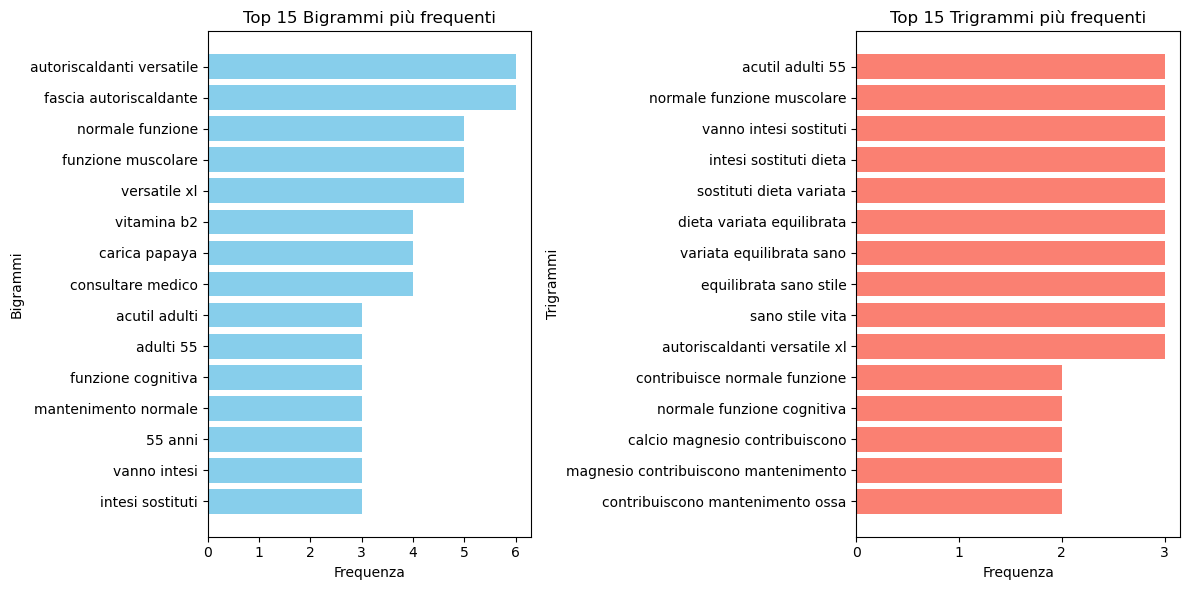

In [8]:
import matplotlib.pyplot as plt

# Estraiamo i bigrammi e i trigrammi più frequenti
top_bigrammi = frequenza_bigrammi.most_common(15)
top_trigrammi = frequenza_trigrammi.most_common(15)

# Estraiamo le parole e le relative frequenze per i bigrammi e i trigrammi
parole_bigrammi = [' '.join(bigramma) for bigramma, _ in top_bigrammi]
frequenze_bigrammi = [frequenza for _, frequenza in top_bigrammi]

parole_trigrammi = [' '.join(trigramma) for trigramma, _ in top_trigrammi]
frequenze_trigrammi = [frequenza for _, frequenza in top_trigrammi]

# Invertiamo l'ordine dei bigrammi e trigrammi e delle relative frequenze
parole_bigrammi = list(reversed(parole_bigrammi))
frequenze_bigrammi = list(reversed(frequenze_bigrammi))

parole_trigrammi = list(reversed(parole_trigrammi))
frequenze_trigrammi = list(reversed(frequenze_trigrammi))

# Creiamo i grafici a barre per i bigrammi e i trigrammi
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(parole_bigrammi, frequenze_bigrammi, color='skyblue')
plt.xlabel('Frequenza')
plt.ylabel('Bigrammi')
plt.title('Top 15 Bigrammi più frequenti')

plt.subplot(1, 2, 2)
plt.barh(parole_trigrammi, frequenze_trigrammi, color='salmon')
plt.xlabel('Frequenza')
plt.ylabel('Trigrammi')
plt.title('Top 15 Trigrammi più frequenti')

# Impostiamo gli assi x del secondo grafico a numeri interi
plt.locator_params(axis='x', integer=True)
plt.xticks()
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Creazione di un oggetto TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Addestramento del modello TF-IDF sulle descrizioni pulite
descrizioni_pulite_testo = [' '.join(descrizione) for descrizione in descrizioni_df['Descrizione_Pulita']]
tfidf_matrix = tfidf_vectorizer.fit_transform(descrizioni_pulite_testo)

# Estrazione delle feature (parole) dal TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calcolo del TF-IDF medio per ciascuna parola
mean_tfidf = tfidf_matrix.mean(axis=0).tolist()[0]

# Creazione di un DataFrame per le parole e i relativi TF-IDF medi
tfidf_df = pd.DataFrame({'Parola': feature_names, 'TF-IDF Medio': mean_tfidf})

# Ordiniamo il DataFrame per TF-IDF in ordine decrescente
tfidf_df = tfidf_df.sort_values(by='TF-IDF Medio', ascending=False)

# Visualizziamo le prime 20 parole chiave con il TF-IDF medio più alto
print("Parole chiave con TF-IDF medio più alto:")
print(tfidf_df.head(20))


Parole chiave con TF-IDF medio più alto:
              Parola  TF-IDF Medio
769         vitamina      0.109650
421         magnesio      0.080310
88   autoriscaldanti      0.078942
55          amuchina      0.074767
475          normale      0.073388
504           papaya      0.072199
706      tachipirina      0.067935
128             casa      0.059814
415             luca      0.059814
757        versatile      0.059207
327         funzione      0.054984
439           medico      0.051903
568         prodotto      0.048308
289           fascia      0.047989
235           dolore      0.046050
773               xl      0.046050
708           tavola      0.044860
647           scopri      0.044860
559            prima      0.042873
259          energya      0.041256


# TF-IDF più alto

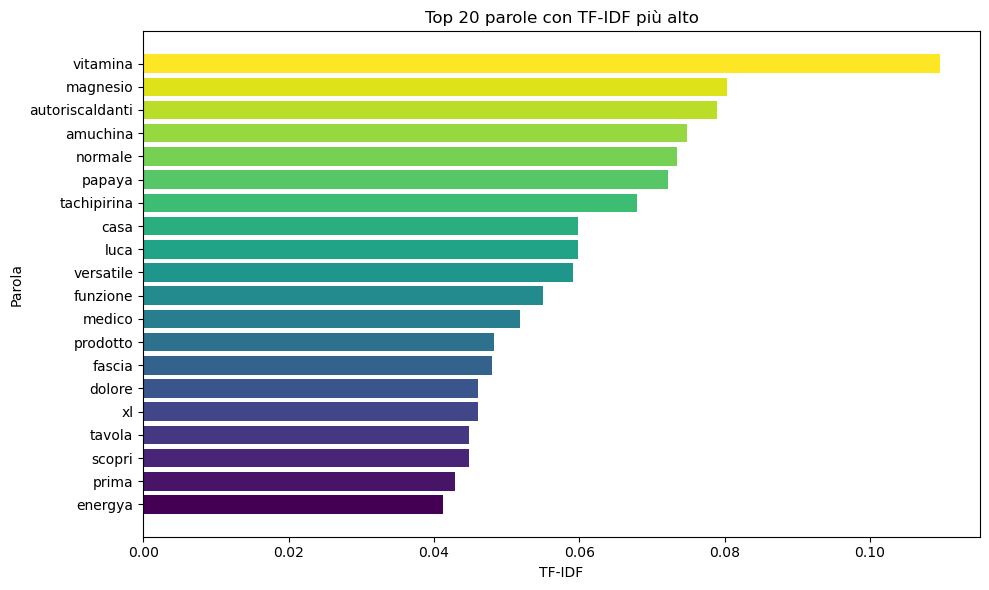

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Estrai le prime 20 parole chiave e i loro punteggi TF-IDF medi da tfidf_df
top_keywords = tfidf_df['Parola'].head(20)
top_tfidf_scores = tfidf_df['TF-IDF Medio'].head(20)

# Crea una scala di colori viridis basata sui valori TF-IDF medi (in ordine inverso)
viridis_colors = plt.cm.viridis(np.linspace(1, 0, len(top_keywords)))  # Invertiamo l'ordine qui

# Crea il grafico a barre per le prime parole chiave con i punteggi TF-IDF medi più alti
plt.figure(figsize=(10, 6))
bars = plt.barh(top_keywords, top_tfidf_scores, color=viridis_colors)

plt.xlabel('TF-IDF')
plt.ylabel('Parola')
plt.title('Top 20 parole con TF-IDF più alto')
plt.gca().invert_yaxis()  # Invertiamo l'asse y per mostrare la parola chiave con il TF-IDF più alto in cima
plt.tight_layout()  # Impostiamo i margini per evitare il taglio delle etichette
plt.show()


# Heatmap Similarità Coseno

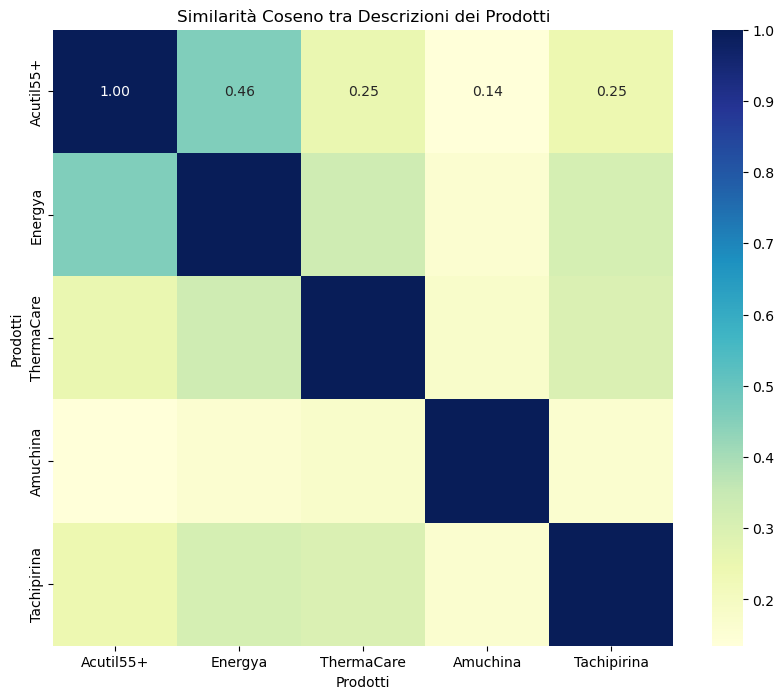

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Carica il file CSV contenente le descrizioni dei prodotti
df = pd.read_csv("descrizioni_prodotti.csv")

# Estrai gli identificatori univoci dei prodotti
product_ids = df['Prodotto'].tolist()

# Estrai le descrizioni dei prodotti
descriptions = df['Descrizione'].tolist()

# Inizializza il vettorizzatore TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Calcola le rappresentazioni TF-IDF delle descrizioni dei prodotti
tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions)

# Calcola la similarità coseno tra le descrizioni dei prodotti
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Visualizza la similarità coseno come heatmap con etichette sui prodotti e valori nelle celle
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cosine_similarities, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=product_ids, yticklabels=product_ids)
heatmap.set_title('Similarità Coseno tra Descrizioni dei Prodotti')
plt.xlabel('Prodotti')
plt.ylabel('Prodotti')
plt.show()


# Sentiment Analysis

In [16]:
import pandas as pd
import nltk
from textblob import TextBlob

# Funzione per caricare il lexicon da un file
def load_lexicon(filename):
    lexicon = {}
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            if not line.strip():
                continue
            parts = line.strip().split('\t')
            word = parts[0]
            sentiment = float(parts[3])
            lexicon[word.lower()] = sentiment
    return lexicon

# Funzione per analizzare il sentiment utilizzando NLTK
def analyze_sentiment_with_nltk(description, lexicon):
    words = nltk.word_tokenize(description.lower())
    total_sentiment = sum(lexicon.get(word, 0) for word in words)
    if total_sentiment > 0:
        return "Positivo"
    elif total_sentiment < 0:
        return "Negativo"
    else:
        return "Neutrale"

def analyze_sentiment_with_textblob(description, lexicon):
    blob = TextBlob(description)
    sentiment_score = sum(lexicon.get(word.lower(), 0) for word in blob.words)
    polarity = blob.sentiment.polarity
    intensity = blob.sentiment.subjectivity
    
    # Considera neutro se il punteggio di sentimento è vicino allo zero
    if -0.1 <= sentiment_score <= 0.1:
        sentiment = "Neutro"
    elif sentiment_score > 0:
        sentiment = "Positivo"
    else:
        sentiment = "Negativo"
    
    return sentiment, polarity, intensity

# Carica il lexicon
lexicon = load_lexicon('sentix')  # Assicurati che il nome del file e il percorso siano corretti

# Carica le descrizioni dei prodotti dal file CSV
df = pd.read_csv('descrizioni_prodotti.csv')

# Prendi fino al quarto prodotto per l'analisi
df_subset = df.head(4)

# Analizza il sentiment per ogni descrizione utilizzando NLTK
print("Analisi del sentiment utilizzando NLTK:")
for index, row in df_subset.iterrows():
    sentiment = analyze_sentiment_with_nltk(row['Descrizione'], lexicon)
    print(f"Prodotto: '{row['Prodotto']}' - Descrizione: '{row['Descrizione']}' - Sentiment: {sentiment}")

print("\n")

# Prendi il quinto prodotto per l'analisi
fifth_product_description = " "
with open("bugiardino_tachipirina.txt", "r", encoding="utf-8") as file:
    fifth_product_description = file.read()

# Analizza il sentiment per il quinto prodotto utilizzando NLTK
print("Analisi del sentiment per il quinto prodotto utilizzando NLTK:")
sentiment = analyze_sentiment_with_nltk(fifth_product_description, lexicon)
print(f"Descrizione: '{fifth_product_description}' - Sentiment: {sentiment}")

print("\n")

# Analizza il sentiment per ogni descrizione utilizzando TextBlob
print("Analisi del sentiment utilizzando TextBlob:")
for index, row in df_subset.iterrows():
    sentiment = analyze_sentiment_with_textblob(row['Descrizione'], lexicon)
    print(f"Prodotto: '{row['Prodotto']}' - Descrizione: '{row['Descrizione']}' - Sentiment: {sentiment}")

print("\n")

# Analizza il sentiment per il quinto prodotto utilizzando TextBlob
print("Analisi del sentiment per il quinto prodotto utilizzando TextBlob:")
sentiment, polarity, intensity = analyze_sentiment_with_textblob(fifth_product_description, lexicon)
print(f"Descrizione: '{fifth_product_description}'")
print(f"Sentiment: {sentiment}")
print(f"Polarità: {polarity:.2f}")
print(f"Intensità: {intensity:.2f}")


Analisi del sentiment utilizzando NLTK:
Prodotto: 'Acutil55+' - Descrizione: 'ACUTIL ADULTI 55+ Vuoi mantenere giovane la tua vitalità? C'è un nuovo alleato per mente, ossa e muscoli. Compresse con Resveratrolo. Con Zinco, che contribuisce alla normale funzione cognitiva. Con Calcio e Magnesio, che contribuiscono al mantenimento di ossa normali e alla normale funzione muscolare. Con Vitamina B2, che contribuisce al mantenimento della normale capacità visiva. Supporta le esigenze nutrizionali specifiche in questa fascia di eta, insieme ad Acutil Adulti 55+, per mantenere mente e fisico sani e vitali. Le esigenze nutrizionali di ognuno di noi variano nelle diverse fasi della vita. Superati i 50 anni, il nostro corpo manifesta dei nuovi bisogni e diventa fondamentale garantire il corretto apporto di Vitamine e Minerali. Una dieta povera di questi nutrienti può influire sull'indebolimento muscolare e osseo, nonché aumentare la percezione di affaticamento mentale. ACUTIL ADULTI 55+ è un int